Goal: compare the performance of the classifiers (k-nearest neighbors, logistic regression, decision trees, and support vector machines)
Business Case: The dataset pertains to the campaigns that were initiated to offer long term deposit applications with good interest rates. Data includes information about contacted individuals such as age, job status, education, marital status, housing, personal loan, default etc.
Business Problem: Essentially, we want to analyze the data available to draw actionable inferences about the success rate in acceptance of deposit applications from the fields (features) about the individuals available to us. 

In [ ]:
# As a first step, we import libraries and tools that we anticipate needing for this exercise. Considering the goal of modeling classification tools,
# we would like to import all libraries and tools to faciliate logistic regression, KNN, SVM and decision tree classifications.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.compose import make_column_transformer
from sklearn.metrics import confusion_matrix
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from sklearn import metrics

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
import time

In [3]:
# Data are saved in a local drive and imported here as a first step
df = pd.read_csv('C:\\ml\MLAI\\bank+marketing\\bank-additional\\bank-additional\\bank-additional-full.csv', sep = ';')

In [4]:
# Once data are in memory, we review the fields and other aspects of the dimensions of data to get a better feel for what is available and useful.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# Here we check for any missing fields.
df.isna().any()

age               False
job               False
marital           False
education         False
default           False
housing           False
loan              False
contact           False
month             False
day_of_week       False
duration          False
campaign          False
pdays             False
previous          False
poutcome          False
emp.var.rate      False
cons.price.idx    False
cons.conf.idx     False
euribor3m         False
nr.employed       False
y                 False
dtype: bool

In [6]:
df.shape

(41188, 21)

In [7]:
# Here we rename some of the difficult to read columns into standard economic terms such as CPI.
df_new = df.rename(columns={"emp.var.rate": "EmpVarRate", "cons.price.idx": "CPI","cons.conf.idx":"CCI","nr.employed":"NE"})
df_new.select_dtypes('object').columns[:-1] 

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome'],
      dtype='object')

In [8]:
#In this step we check for null, empty/NaNs in the data
empty_values = df[df.isnull().all(axis=1)]
nan_values = df[df.isna().any(axis=1)]
null_values = df[df.isnull().any(axis=1)]

In [9]:
print("Rows with all values empty:")
print(empty_values)
print("\nRows with any NaN values:")
print(nan_values)
print("\nRows with any null/missing values:")
print(null_values)

Rows with all values empty:
Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y]
Index: []

[0 rows x 21 columns]

Rows with any NaN values:
Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y]
Index: []

[0 rows x 21 columns]

Rows with any null/missing values:
Empty DataFrame
Columns: [age, job, marital, education, default, housing, loan, contact, month, day_of_week, duration, campaign, pdays, previous, poutcome, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed, y]
Index: []

[0 rows x 21 columns]


In [10]:
# Here we use the normalize tool to address fields classified as unknown
job = df_new['job'].value_counts(normalize = True)
marital = df_new['marital'].value_counts(normalize = True)
education= df_new['education'].value_counts(normalize = True)
default = df_new['default'].value_counts(normalize = True)
housing = df_new['housing'].value_counts(normalize = True)
loan = df_new['loan'].value_counts(normalize = True)
contact = df_new['contact'].value_counts(normalize = True)
month = df_new['month'].value_counts(normalize = True)
day_of_week = df_new['day_of_week'].value_counts(normalize = True)
poutcome = df_new['poutcome'].value_counts(normalize = True)

df_filtered = df_new [(df_new.job != 'unknown')] 
df_filtered = df_filtered [(df_filtered.marital != 'unknown')] 
df_filtered = df_filtered [(df_filtered.education != 'unknown')] 
df_filtered = df_filtered [(df_filtered.housing != 'unknown')] 
df_filtered = df_filtered [(df_filtered.loan != 'unknown')] 
df_filtered = df_filtered [(df_filtered.default != 'unknown')] 
df_filtered.info()      

The next step is a major visualization exercise with the goal of developing a good feel for the data and cross-relationships intuitively.
Towards this, I use the seaborn tool to chart various acceptance rates.

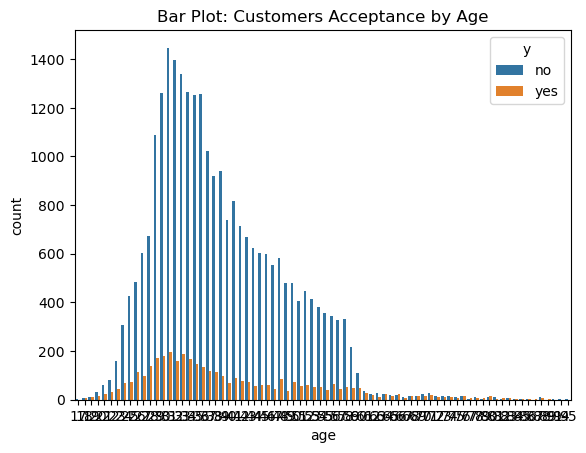

In [12]:
#Creating a bar plot of acceptance by age, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.
df_sns1 = df_filtered[['age','y']]

#define countplot using seaborn
fig = sns.countplot(df_sns1, x = 'age', hue = 'y')
#assign title
fig.set_title('Bar Plot: Customers Acceptance by Age')
#display
plt.show()

Visual inspection seems to corroborate that the shape of distributions of both 'yes' and 'no' responses by age are somewhat comparable although it is obvious that no response far exceeds the yes for all age groups except perhaps in the tails of the distribution where there may not be enough data to justify accurate inferencing.

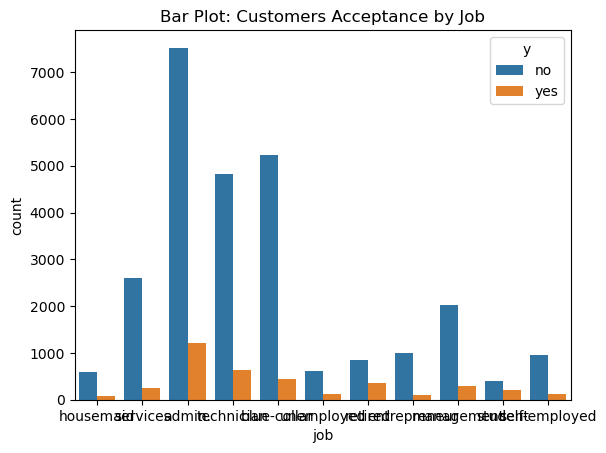

In [13]:
#Creating a bar plot of acceptance by job status, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.

df_sns2 = df_filtered[['job','y']]

#define countplot using seaborn
fig = sns.countplot(df_sns2, x = 'job', hue = 'y')

#assign title
fig.set_title('Bar Plot: Customers Acceptance by Job')

#display
plt.show()

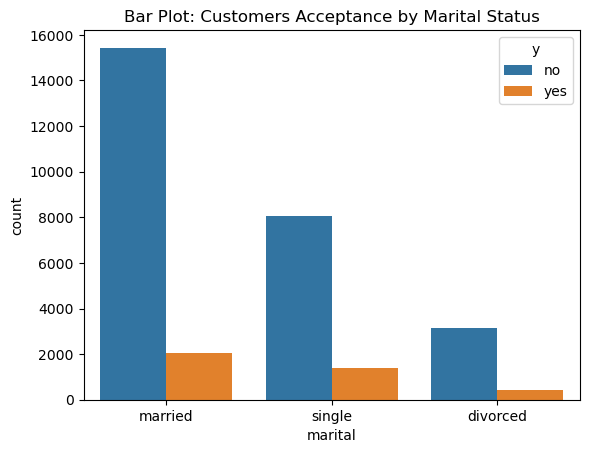

In [14]:
#Creating a bar plot of acceptance by marital status, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.

#First we define a countplot using seaborn, then we define the title and finally display the chart.

df_sns3 = df_filtered[['marital','y']]
fig = sns.countplot(df_sns3, x = 'marital', hue = 'y')
fig.set_title('Bar Plot: Customers Acceptance by Marital Status')
plt.show()

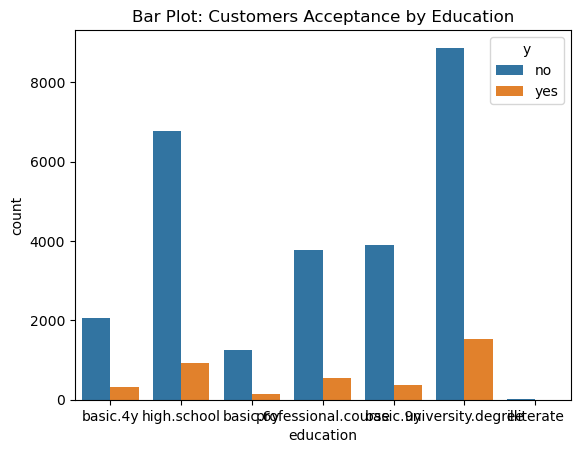

In [15]:
#Creating a bar plot of acceptance by education, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.

#First we define a countplot using seaborn, then we define the title and finally display the chart.

df_sns4 = df_filtered[['education','y']]
fig = sns.countplot(df_sns4, x = 'education', hue = 'y')
fig.set_title('Bar Plot: Customers Acceptance by Education')
plt.show()

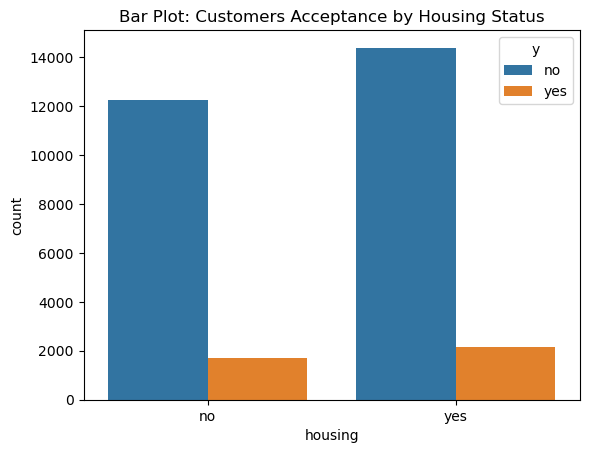

In [16]:
#Creating a bar plot of acceptance by housing, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.


#First we define a countplot using seaborn, then we define the title and finally display the chart.

df_sns5 = df_filtered[['housing','y']]
fig = sns.countplot(df_sns5, x = 'housing', hue = 'y')
fig.set_title('Bar Plot: Customers Acceptance by Housing Status')
plt.show()

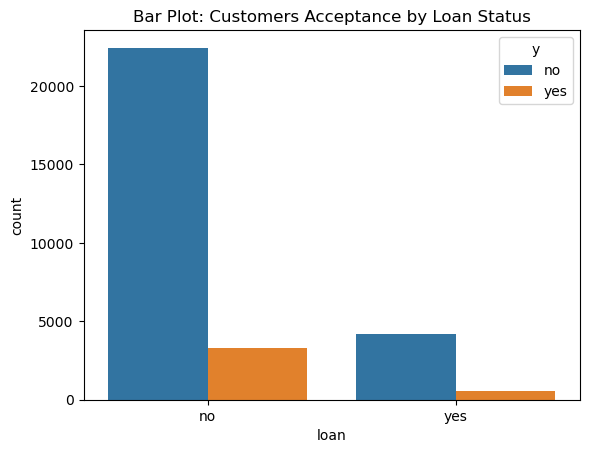

In [17]:
#Creating a bar plot of acceptance by loan status, by initially filtering the original dataframe to the fields we desire for this analysis.
# Although it is possible this dataframe will not be used elsewhere, the intention is to have it available should other relationships be explored, without needing to 
#go back to the original core dataframe.


#First we define a countplot using seaborn, then we define the title and finally display the chart.

df_sns6 = df_filtered[['loan','y']]
fig = sns.countplot(df_sns6, x = 'loan', hue = 'y')
fig.set_title('Bar Plot: Customers Acceptance by Loan Status')
plt.show()

Initial visual inspection of data: 

Marital Status - There was greater success with married, followed by single
Housing - Customers with housing tended to have higher acceptance
Loans - customers without loans tended to have more appeal for the deposit application
Job - admins, technical staff and blue collar workers tended to show more reception

Business objective:
We would like to attribute/understand features that lead to greater success rate. In order to do that, we would attempt to answer questions such as:
Which features have positive impact on success rate?
Which features tend to have greater impact? Which type of customers to focus?
Would there be more success with customers with a certain type of education or certain type of job?
Are the features that make customers less attractive for this product?

In [18]:
# Now we create a filtered dataset that we would like to work with, based on the inferences drawn from visual inspection above.
# We strip out these data into a new dataframe to maintain the integrity of the original dataset.
df_iter1 = pd.DataFrame(df_filtered[['job','marital','education','default','housing','loan','contact','y']])
df_iter1.reset_index(inplace= True)
df_iter1 = df_iter1.drop('index', axis = 1)

In [19]:
# We now define the features as feature columns and then define our X and y for the purpose of analysis. We convert the y into a binary data vector.
feature_cols = [
    'job', 'marital', 'education', 'default', 'housing',
    'loan','contact']


X = df_iter1[feature_cols]
y = df_iter1['y']
y_filtered = np.where(y == 'no', 0, 1)

In [20]:
# Now we create an initial transformer that will feed into all the classification models we will build. The transformer performs 
# one hot encoding on the binary vectors and ordinal encoding on the non-binary fields. The remainder is applied a standard scaler although
# considering this dataset, at the moment it is less relevant than the above 2 fields.

transformer = ''
X_filtered = ''
#y_filtered = ''
    
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['job', 'marital', 'education', 'default','contact']),
                                     (OrdinalEncoder(), ['housing','loan']),
                                     remainder = StandardScaler())
X_filtered = transformer.fit_transform(X)#.toarray()

#y_filtered = np.where(y == 'no', 0, 1)

In [21]:
# Now we split the data into training and test dataset with a 70% and 30% allocation.
X_train, X_test, y_train, y_test = train_test_split(X, y_filtered, test_size=0.3, random_state=42)
#X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(X_filtered, y_filtered, test_size=0.3, random_state=42)

Now that the initial setup of datafields is done, modeling will begin in earnest.
The models will have standard steps:
1. Define the pipeline
2. Fitting to the training data
3. Predicting the test data
4. Analysing the accuracy of the tested and trained results.

*FIRST MODEL: LOGISTIC REGRESSION

In [22]:
#Define logisitic regression pipleine, calling the transformer defined above, apply standard scaler and define the model to be used

logreg_pipe = Pipeline ([
    ('transformer', transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression())
])

In [23]:
#Fit pipeline to training data
logreg = logreg_pipe.fit(X_train, y_train)

In [24]:
# Make prediction on the test data and obtain probabilities based on the results
logreg_pred = logreg.predict(X_test)
y_logreg_proba = logreg.predict_proba(X_test)
yes_logrreg_probs = y_logreg_proba[::,1]
no_logrreg_probs = y_logreg_proba[::,0]

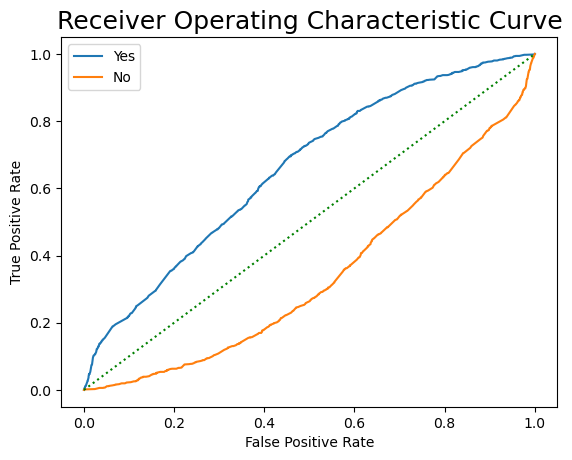

In [25]:
#Chart the ROC curve by using the probability vectors obtained from the previous step

fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=yes_logrreg_probs)
fpr1, tpr1, threshold1 = metrics.roc_curve(y_true=y_test,  y_score=no_logrreg_probs)

plt.plot(fpr,tpr, label="Yes")
plt.plot(fpr1,tpr1, label="No")
plt.legend(loc="upper left")
plt.title('Receiver Operating Characteristic Curve', size=18)
plt.plot([0, 1], [0, 1], color='green', linestyle=':')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_true=y_test, y_score=yes_logrreg_probs)
print("Area under curve is {:.6f}".format(round(auc, 2)))

Area under curve is 0.660000


One may infer that Yes is closer to top-left corner indicating better performance than the Deposit = No. With the ROC AUC score over 0.5, this means that the classifer can detect more numbers of True positives and True negatives than False negatives and False positives.

In [26]:
# Here we evaluate the training accuracy, test accuracy, precision, recall and f1 scores from the logistic regression exercise.

#log_reg_train = LogisticRegression().fit(X_train_alt, y_train_alt)
#acc_train = log_reg_train.score(X_train_alt, y_train_alt)

logreg_train_accuracy = logreg.score(X_train, y_train)
logreg_test_accuracy = accuracy_score(y_test, logreg_pred)
logreg_precision = precision_score(y_test, logreg_pred, average='macro')
logreg_recall = recall_score(y_test, logreg_pred, average='macro')
logreg_f1 = f1_score(y_test, logreg_pred, average='macro')

print("Train Accuracy: {:.6f}".format(logreg_train_accuracy))
print("Test Accuracy: {:.6f}".format(logreg_test_accuracy))
print("Precision: {:.6f}".format(logreg_precision))
print("Recall: {:.6f}".format(logreg_recall))
print("F1-score: {:.6f}".format(logreg_f1))

Train Accuracy: 0.874092
Test Accuracy: 0.871761
Precision: 0.435881
Recall: 0.500000
F1-score: 0.465744


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results show that accuracy scores were over 85% for both training and test data, but recall, precision and F1_Score were at or below 50%.
This means the classifier has a high number of False negatives which may be due to imbalanced classes or poorly tuned model hyperparameters. 

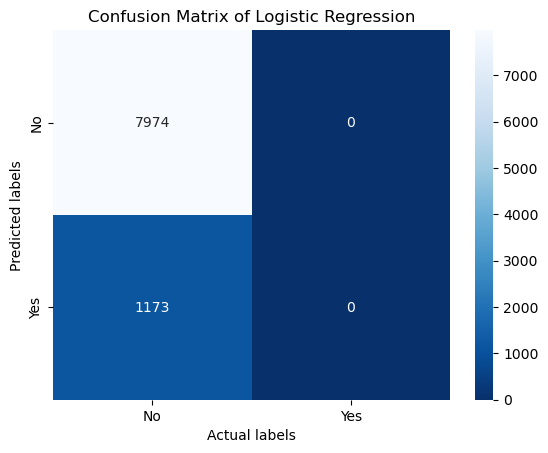

In [27]:
# Here we develop the confusion matrix for the logistic regression exercise above
ax= plt.subplot()
logreg_conf_matrix = confusion_matrix(y_test, logreg_pred)
sns.heatmap(logreg_conf_matrix, annot = True, cmap = 'Blues_r', fmt = 'd', ax=ax)

ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix of Logistic Regression'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); 
ax.yaxis.set_ticklabels(['No', 'Yes']);

plt.show()

A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. A good model is one which has high TP and TN rates, while low FP and FN rates.

This confusion matrix has a high number of TP rates with no TN. A low recall score (<0.5) means your classifier has a high number of False negatives which can be an outcome of imbalanced class or untuned model hyperparameters. A low precision score (<0.5) means your classifier has a high number of False positives which can be an outcome of imbalanced class or untuned model hyperparameters.

In [28]:
# Here we develop the k nearest neighbour classification model, first by creating a pipeline - similar to logistic regression by calling the transformer
# defined above, applying standard scaler and defining the model as KNN.


#knn = KNeighborsClassifier().fit(X_train_alt, y_train_alt)
knn_pipe = Pipeline ([
    ('transformer', transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', KNeighborsClassifier())
])

#Here we train the model on the training dataset
knn = knn_pipe.fit(X_train, y_train)

#Predict on the test data
#knn_pred = knn.predict(X_test_alt)
knn_pred = knn.predict(X_test)

#acc_test = knn.score(X_test_alt, y_test_alt)
#acc_train = knn.score(X_train_alt, y_train_alt)

#precision = precision_score(y_test_alt, knn_pred, average='macro')
#recall = recall_score(y_test_alt, knn_pred, average='macro')
#f1 = f1_score(y_test_alt, knn_pred, average='macro')

#Calculate accuracy scores
knn_test_accuracy = knn.score(X_test, y_test)
knn_train_accuracy = knn.score(X_train, y_train)
knn_precision = precision_score(y_test, knn_pred, average='macro')
knn_recall = recall_score(y_test, knn_pred, average='macro')
knn_f1 = f1_score(y_test, knn_pred, average='macro')

print("Train Accuracy: {:.6f}".format(knn_train_accuracy))
print("Test Accuracy: {:.6f}".format(knn_test_accuracy))
print("Precision: {:.6f}".format(knn_precision))
print("Recall: {:.6f}".format(knn_recall))
print("F1-score: {:.6f}".format(knn_f1))

Train Accuracy: 0.867204
Test Accuracy: 0.860719
Precision: 0.568941
Recall: 0.514026
F1-score: 0.502730


Results show that accuracy scores were over 85% for both training and test data, and recall, precision and F1_Score were very slightly above 50%.
This means the classifier has a high number of False negatives which may be due to imbalanced classes or poorly tuned model hyperparameters. 

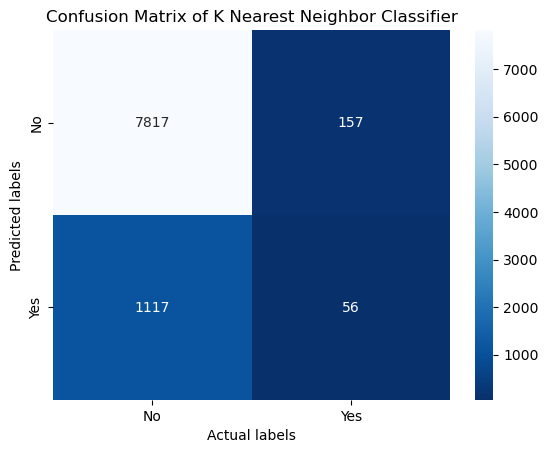

In [29]:
# Similar to logistic regression, we develop the confusion matrix for knn model
ax= plt.subplot()
knn_conf_matrix = confusion_matrix(y_test, knn_pred)
sns.heatmap(knn_conf_matrix, annot = True, cmap = 'Blues_r', fmt = 'd', ax=ax)

ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix of K Nearest Neighbor Classifier'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); 
ax.yaxis.set_ticklabels(['No', 'Yes']);

plt.show()

A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. A good model is one which has high TP and TN rates, while low FP and FN rates.

This confusion matrix has a high number of TP rates with no TN. A low recall score (<0.5) means your classifier has a high number of False negatives which can be an outcome of imbalanced class or untuned model hyperparameters. A low precision score (<0.5) means your classifier has a high number of False positives which can be an outcome of imbalanced class or untuned model hyperparameters.

In [30]:
# Now we develop the third model - the decision tree classifier. We begin by defining the pipeline, then we fit the training data and 
# calculate predictions on training data. This is followed by calculation of accuracy scores.
dt_pipe = Pipeline ([
    ('transformer', transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier())
])

dt = dt_pipe.fit(X_train, y_train)

#knn_pred = knn.predict(X_test_alt)
dt_pred = dt.predict(X_test)

#dt = DecisionTreeClassifier().fit(X_train, y_train)
#dt_pred = dt.predict(X_test)

dt_test_accuracy = dt.score(X_test, y_test)
dt_train_accuracy = dt.score(X_train, y_train)

dt_precision = precision_score(y_test, dt_pred, average='macro')
dt_recall = recall_score(y_test, dt_pred, average='macro')
dt_f1 = f1_score(y_test, dt_pred, average='macro')

print("Train Accuracy: {:.6f}".format(dt_train_accuracy))
print("Test Accuracy: {:.6f}".format(dt_test_accuracy))
print("Precision: {:.6f}".format(dt_precision))
print("Recall: {:.6f}".format(dt_recall))
print("F1-score: {:.6f}".format(dt_f1))

Train Accuracy: 0.877044
Test Accuracy: 0.870012
Precision: 0.599424
Recall: 0.504450
F1-score: 0.477488


Results show that accuracy scores were over 85% for both training and test data, but F1_Score was below 50%. Precision score is 0.599, much better than the previous models.
This means the classifier has a high number of False negatives which may be due to imbalanced classes or poorly tuned model hyperparameters. 

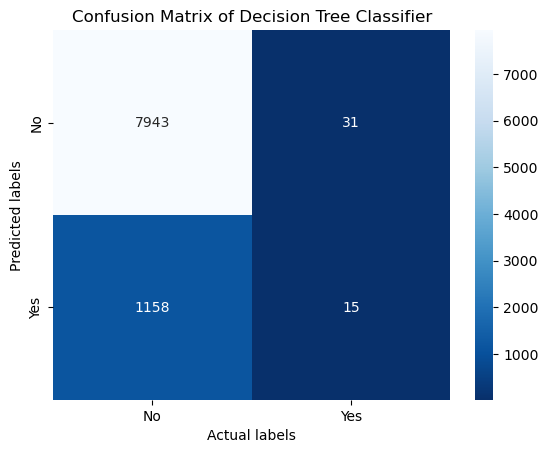

In [31]:
# Here we develop the confusion matrix for the knn model
ax= plt.subplot()
dt_conf_matrix = confusion_matrix(y_test, dt_pred)
sns.heatmap(dt_conf_matrix, annot = True, cmap = 'Blues_r', fmt = 'd', ax=ax)

ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix of Decision Tree Classifier'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); 
ax.yaxis.set_ticklabels(['No', 'Yes']);

plt.show()

A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. A good model is one which has high TP and TN rates, while low FP and FN rates.

This confusion matrix has a high number of TP rates with no TN. A low recall score (<0.5) means your classifier has a high number of False negatives which can be an outcome of imbalanced class or untuned model hyperparameters. A low precision score (<0.5) means your classifier has a high number of False positives which can be an outcome of imbalanced class or untuned model hyperparameters.

In [32]:
# Now we develop the fourth model, the support vector machine classifier. Similar to the rest, we develop a pipeline, train the model on training data
# then predict on the test data. This is followed by calculating various accuracy and performance scores.

svc_pipe = Pipeline ([
    ('transformer', transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC())
])

svc = svc_pipe.fit(X_train, y_train)

#knn_pred = knn.predict(X_test_alt)
svc_pred = svc.predict(X_test)

#svc = SVC().fit(X_train_alt, y_train_alt)
#svc_pred = svc.predict(X_test_alt)

svc_test_accuracy = svc.score(X_test, y_test)
svc_train_accuracy = svc.score(X_train, y_train)

svc_precision = precision_score(y_test, svc_pred, average='macro')
svc_recall = recall_score(y_test, svc_pred, average='macro')
svc_f1 = f1_score(y_test, svc_pred, average='macro')

print("Train Accuracy: {:.6f}".format(svc_train_accuracy))
print("Test Accuracy: {:.6f}".format(svc_test_accuracy))
print("Precision: {:.6f}".format(svc_precision))
print("Recall: {:.6f}".format(svc_recall))
print("F1-score: {:.6f}".format(svc_f1))

Train Accuracy: 0.874280
Test Accuracy: 0.871543
Precision: 0.435867
Recall: 0.499875
F1-score: 0.465681


Results show that accuracy scores were over 85% for both training and test data, but recall, precision and F1_Score were below 50%.
This means the classifier has a high number of False negatives which may be due to imbalanced classes or poorly tuned model hyperparameters. 

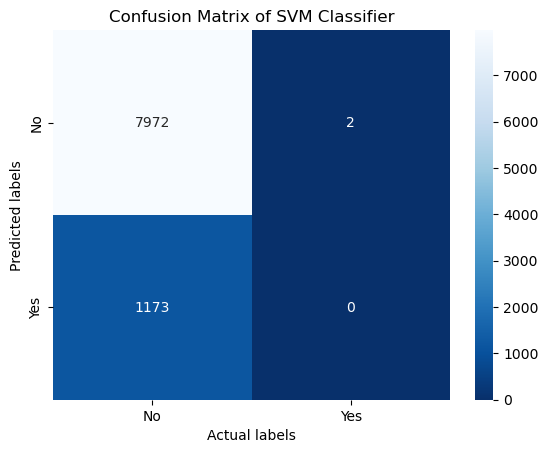

In [33]:
ax= plt.subplot()
svc_conf_matrix = confusion_matrix(y_test, svc_pred)
sns.heatmap(svc_conf_matrix, annot = True, cmap = 'Blues_r', fmt = 'd', ax=ax)

ax.set_xlabel('Actual labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix of SVM Classifier'); 
ax.xaxis.set_ticklabels(['No', 'Yes']); 
ax.yaxis.set_ticklabels(['No', 'Yes']);

plt.show()

A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the machine learning model. A good model is one which has high TP and TN rates, while low FP and FN rates.

This confusion matrix has a high number of TP rates with no TN. A low recall score (<0.5) means your classifier has a high number of False negatives which can be an outcome of imbalanced class or untuned model hyperparameters. A low precision score (<0.5) means your classifier has a high number of False positives which can be an outcome of imbalanced class or untuned model hyperparameters.

In [34]:
#Now we create a dataframe to compare the results of the 4 models. This is immediately one of the objectives of this exercise.
pd.DataFrame({'Model': ['Logistic Regression','K Nearest Neighbors','Decision Tree','Support Vector Machines'], 
             'Train Accuracy': [logreg_train_accuracy,knn_train_accuracy,dt_train_accuracy,svc_train_accuracy],
             'Test Accuracy': [logreg_test_accuracy,knn_test_accuracy,dt_test_accuracy,svc_test_accuracy],
             'Precision': [logreg_precision,knn_precision,dt_precision,svc_precision],
             'Recall': [logreg_recall,knn_recall,dt_recall,svc_recall],
             'F1_Score': [logreg_f1,knn_f1,dt_f1,svc_f1]})

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1_Score
0,Logistic Regression,0.874092,0.871761,0.435881,0.500000,0.465744
1,K Nearest Neighbors,0.867204,0.860719,0.568941,0.514026,0.502730
2,Decision Tree,0.877044,0.870012,0.599424,0.504450,0.477488
3,Support Vector Machines,0.874280,0.871543,0.435867,0.499875,0.465681


Decision tree has the best training accuracy but the SVM model performs better on test data even though its training accuracy is lower than the decision tree model. However,the SVM model precision and recall and F1 scores, all are below 0.5 whereas the KNN model has precision, recall and F1 scores at or above 0.5 which is an important observation regarding model selection. Its test accuracy however, is the lowest among all 4 models.
Logistic regression compares to SVM on training and test accuracy and similar to SVM, has at or below 0.5 on precision, recall and F1.
These are generally indicative of poor tuning of hyperparameters or imbalanced class.

***********
Now we attempt to improve the above iterations by using grid search CV and introducing additional parameters to improve our models.

In [35]:
# As a first step, we define the parameters to the model, the grid search criteria and then fit the model to training data.
# We follow this by predicting on the test data and finally evaluating the results of the model.

logreg_parameters = {
    'model__penalty' : ['l1','l2'], 
    'model__C'       : np.logspace(-3,3,7),
    'model__solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

grid_search_logreg = GridSearchCV(estimator=logreg_pipe,
            param_grid=logreg_parameters,
            scoring='accuracy',
            cv=10)

gs_logreg = grid_search_logreg.fit(X_train, y_train)
gs_logreg_pred = gs_logreg.predict(X_test)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 420, in fit
    self._final_estimator.f

In [37]:
print('\n Logistic Regression - Grid Search best score -')
print(gs_logreg.best_score_)

print('\nGrid Search best parameters -')
print(gs_logreg.best_params_)

print('\Grid Search Results -')
print(gs_logreg.cv_results_)

print("Best parameters:")
print(gs_logreg.best_estimator_.steps)

logreg_iter2 = gs_logreg.best_estimator_
print('Test accuracy: %.3f' % logreg_iter2.score(X_test, y_test))

print("Best cross-validation score:", gs_logreg.best_score_)

score = gs_logreg.score(X_test, y_test)
print("Test Score :", score)


 Logistic Regression - Grid Search best score -
0.874138987596821

Grid Search best parameters -
{'model__C': 0.001, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
\Grid Search Results -
{'mean_fit_time': array([0.02600796, 0.02343104, 0.03514588, 0.07150614, 0.03838077,
       0.03302832, 0.02624249, 0.02509217, 0.03844104, 0.08868442,
       0.040588  , 0.03647456, 0.02642155, 0.02842627, 0.12588296,
       0.09640176, 0.05348861, 0.03578615, 0.0260309 , 0.02500639,
       0.25343113, 0.09943879, 0.05456867, 0.04163344, 0.02494097,
       0.02473693, 0.09887064, 0.10440071, 0.04183002, 0.03811302,
       0.02615778, 0.0277451 , 0.03358366, 0.10466373, 0.04982862,
       0.04034333, 0.02783244, 0.0249907 , 0.03757174, 0.12468324,
       0.04976876, 0.03805599]), 'std_fit_time': array([0.00641292, 0.00794856, 0.00495089, 0.00651171, 0.00746348,
       0.00380498, 0.00834929, 0.00735135, 0.00775427, 0.0078621 ,
       0.00782222, 0.00656726, 0.00879674, 0.0078246 , 0.03558388,
 

In [38]:
# As a first step, we define the parameters to the model, the grid search criteria and then fit the model to training data.
# We follow this by predicting on the test data and finally evaluating the results of the model.

knn_param = {"model__n_neighbors": range(1, 18, 2)}
grid_search_knn = GridSearchCV(knn_pipe, knn_param, cv=10, scoring='accuracy')
grid_search_knn.fit(X_train, y_train)
gs_knn_pred = grid_search_knn.predict(X_test)

print('\nK Nearest Neighbor - Grid Search best score -')
print(grid_search_knn.best_score_)

print('\nGrid Search best parameters -')
print(grid_search_knn.best_params_)

print('\Grid Search Results -')
print(grid_search_knn.cv_results_)

print("Best parameters :")
print(grid_search_knn.best_estimator_.steps)

knn_iter2 = grid_search_knn.best_estimator_
print('Test accuracy: %.3f' % knn_iter2.score(X_test, y_test))

print("Best cross-validation score:", grid_search_knn.best_score_)

scoreknn = grid_search_knn.score(X_test, y_test)
print("Test Score :", scoreknn)


K Nearest Neighbor - Grid Search best score -
0.8725926397415327

Grid Search best parameters -
{'model__n_neighbors': 15}
\Grid Search Results -
{'mean_fit_time': array([0.03647044, 0.03756802, 0.05482342, 0.04394608, 0.03451405,
       0.03603213, 0.03227522, 0.03059268, 0.03293614]), 'std_fit_time': array([0.00853172, 0.0091039 , 0.02329453, 0.02230029, 0.00464746,
       0.00937413, 0.00838614, 0.00738796, 0.00317688]), 'mean_score_time': array([0.34358184, 0.3526098 , 0.91550882, 0.39622781, 0.3343076 ,
       0.33937743, 0.36649914, 0.35994384, 0.35082722]), 'std_score_time': array([0.02726644, 0.02518428, 0.73443173, 0.11337248, 0.01815388,
       0.02132375, 0.03237838, 0.01051541, 0.0148585 ]), 'param_model__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11, 13, 15, 17],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'params': [{'model__n_neighbors': 1}, {'model__n_neighb

In [39]:
# As a first step, we define the parameters to the model, the grid search criteria and then fit the model to training data.
# We follow this by predicting on the test data and finally evaluating the results of the model.

dt_param =  {
    'model__min_samples_leaf': [1, 2, 3, 4],
    'model__max_depth': [1, 2, 3, 4],
    'model__criterion': ['entropy','gini']
}

grid_Search_dt = GridSearchCV(estimator=dt_pipe,
                     param_grid = dt_param,
                     cv=10,
                     verbose=2,
                     n_jobs=1)

grid_search_dt = grid_Search_dt.fit(X_train, y_train)
gsDTC_predicted = grid_search_dt.predict(X_test)

print('\nDecision Tree - Grid Search best score -')
print(grid_search_dt.best_score_)

print('\nGrid Search best parameters -')
print(grid_search_dt.best_params_)

print('\Grid Search Results -')
print(grid_search_dt.cv_results_)

print("Best parameters:")
print(grid_search_dt.best_estimator_.steps)

dt_iter2 = grid_search_dt.best_estimator_
print('Test accuracy: %.3f' % dt_iter2.score(X_test, y_test))

print("Best cross-validation score:", grid_search_dt.best_score_)

score = grid_search_dt.score(X_test, y_test)
print("Test Score :", score)

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=entropy, model__max_depth=1, model__min_samples_leaf=1; total time=   0.0s
[CV] END model__criterion=en

In [41]:
# As a first step, we define the parameters to the model, the grid search criteria and then fit the model to training data.
# We follow this by predicting on the test data and finally evaluating the results of the model.

svc_pipe_iter2 = Pipeline ([
    ('transformer', transformer),
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(probability=False))
])

#svc_param = {
#                    'model__C': [ 0.1, 0.5, 1.0 ],
#                    'model__kernel': ['rbf','linear','poly','sigmoid']
#                 }

svc_param = {
                    'model__C': [ 0.1, 0.5, 1.0 ],
                    'model__kernel': ['rbf','linear']
                 }

grid_Search_svc = GridSearchCV(estimator=svc_pipe_iter2,
                     param_grid = svc_param,
                     scoring='accuracy',
                     cv=10,
                     refit=True,
                     n_jobs=1)

grid_Search_svc.fit(X_train, y_train)
grid_Search_svc_pred = grid_Search_svc.predict(X_test)

print('\nSupport Vector - Grid Search best score -')
print(grid_Search_svc.best_score_)

print('\nGrid Search best parameters -')
print(grid_Search_svc.best_params_)

print('\Grid Search Results -')
print(grid_Search_svc.cv_results_)

print("Best parameters :")
print(grid_Search_svc.best_estimator_.steps)

svc_iter2 = grid_Search_svc.best_estimator_
print('Test accuracy: %.3f' % svc_iter2.score(X_test, y_test))

print("Best cross-validation score:", grid_Search_svc.best_score_)

score_svc = grid_Search_svc.score(X_test, y_test)
print("Test Score :", score_svc)


Support Vector - Grid Search best score -
0.874138987596821

Grid Search best parameters -
{'model__C': 0.1, 'model__kernel': 'rbf'}
\Grid Search Results -
{'mean_fit_time': array([2.95565248, 2.27780268, 5.54012496, 2.68995335, 3.50913794,
       2.38555353]), 'std_fit_time': array([0.07603166, 0.15292316, 2.27753751, 0.23678278, 0.295544  ,
       0.08661023]), 'mean_score_time': array([0.2985456 , 0.22076254, 0.47988322, 0.25459578, 0.3199971 ,
       0.22157347]), 'std_score_time': array([0.04266734, 0.02527822, 0.22707352, 0.0216817 , 0.03521567,
       0.01647058]), 'param_model__C': masked_array(data=[0.1, 0.1, 0.5, 0.5, 1.0, 1.0],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_model__kernel': masked_array(data=['rbf', 'linear', 'rbf', 'linear', 'rbf', 'linear'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'model__C': 0.1, 'mode

The updated model iterations yield quite comparable test accuracies for the 4 different types of models, all about 0.87 indicative of high accuracy of > 85%. 
The imbalanced dataset is heavily weighted on unsuccessful marketing campaigns. If the objective were to determine features that are making the marketing campaign unsuccessful, then the models above could be effective.
The results of the above models may be used to understand customer profile that they need to target.
In order to improve the results of the model, one would want to consider introducing deeper dataset if possible of 'Yes' responses which would be truly insightful and value-adding due to the current imbalance in the data.
Additionally, one may want to evaluate other techniques such as Ensemble Techniques and Neural Networks.
It may also be worth evaluating introduction of other features such as net worth, liquid assets, total investments, total household income.